In [65]:
import pandas as pd
pd.options.mode.chained_assignment = None # See https://stackoverflow.com/a/20627316
import json
import re
from collections import defaultdict
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 300

In [66]:
exs_regex_tests = {
    0: [["2019-12-04", "2020-13-32", "1000-13-32", "5987-78-23"],
        ["201-12-04"]],
    1: [["BoNJOUR", "1234"],
        ["s4lut"]],
    2: [["Oh Oh !", "Oh Oh Oh Oh Oh Oh Oh Oh Oh Oh Oh Oh Oh Oh Oh Oh !"],
        ["Oh Oh!", "Oh !", "Oh Oh Oh Oh Oh Oh Oh Oh Oh Oh Oh Oh Oh Oh Oh Oh Oh !"]],
    3: [["**", "****", "******"],
        ["*", "***"]],
    4: [["Jacky Tunning", "Stan Wawrinka"],
        ["jacky tunning", "Jacky tunning", "Matthieu Bovel"]],
    5: [["(1,2), (5,6), (-3,-4), ", "(1,2), "],
        ["(a,b)", "(-1,2),(3,4),"]]
}

In [67]:
def check_regex(regex_string, tests):
    try:
        regex = re.compile(regex_string)
    except:
        return False
    passing, failing = tests
    for test in passing:
        if not re.fullmatch(regex, test): return False
    for test in failing:
        if re.fullmatch(regex, test): return False
    return True

In [68]:
def read_logs(file):
    return pd.read_csv(f"../data/raw/{school}/log.tsv",
                       sep='\t',
                       parse_dates=['timestamp'],
                       usecols=["timestamp", "username", "activityTitle", "type", "itemId", "value"],
                       escapechar='\\')

In [69]:
def parse_exs_logs(logs):
    selection = (logs["activityTitle"] == "0_Exercises") \
            & ((logs["type"] == "reactivetext.blur") | (logs["type"] == "reactivetext.focus")) \
            & logs["value"]
    result = logs[selection]
    result["exId"] = result["itemId"].apply(lambda v: json.loads(v)[1])
    result["regexCorrect"] = result.apply(lambda row: check_regex(row.value, exs_regex_tests[row.exId]), axis=1)
    return result

In [70]:
def get_student_group(student_id):
    return  min((int(student_id) - 1) // 3 + 1, 7)

In [71]:
def compute_score_changes(exs_logs_df):
    current_scores = defaultdict(set)
    score_changes = []
    for _, row in exs_logs_df.iterrows():
        group = get_student_group(row["username"])
        if row.regexCorrect and row.exId not in current_scores[group]:
            current_scores[group].add(row.exId)
            score_changes.append([row.timestamp, group, row.exId, len(current_scores[group])])
    first_time = exs_logs_df.iloc[0]["timestamp"]
    for group in current_scores.keys():
        score_changes.insert(0, [first_time, group, -1, 0])
    return pd.DataFrame.from_records(score_changes, columns=["timestamp", "groupId", "exId", "score"])

In [102]:
colors = ['#ef3b2c','#cb181d','#a50f15','#4292c6','#2171b5','#08519c','#08306b']
def plot_score_changes(score_changes, school):
    fig, ax = plt.subplots()
    for key, data in score_changes.groupby('groupId'):
        data.plot.line(x='timestamp',
                  y='score',
                  ax=ax,
                  label=f"Group {key} ({('text' if key <= 3 else 'video')})",
                  title=f"Group practice @{school.capitalize()}",
                  color=colors[key - 1])
    ax.set_ylabel("Number of correct answers")
    ax.set_xlabel("Time")
    fig.savefig(f"../data/derived/{school}/scores_over_time.jpg")

/Users/mbovel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Possible nested set at position 1
  This is separate from the ipykernel package so we can avoid doing imports until


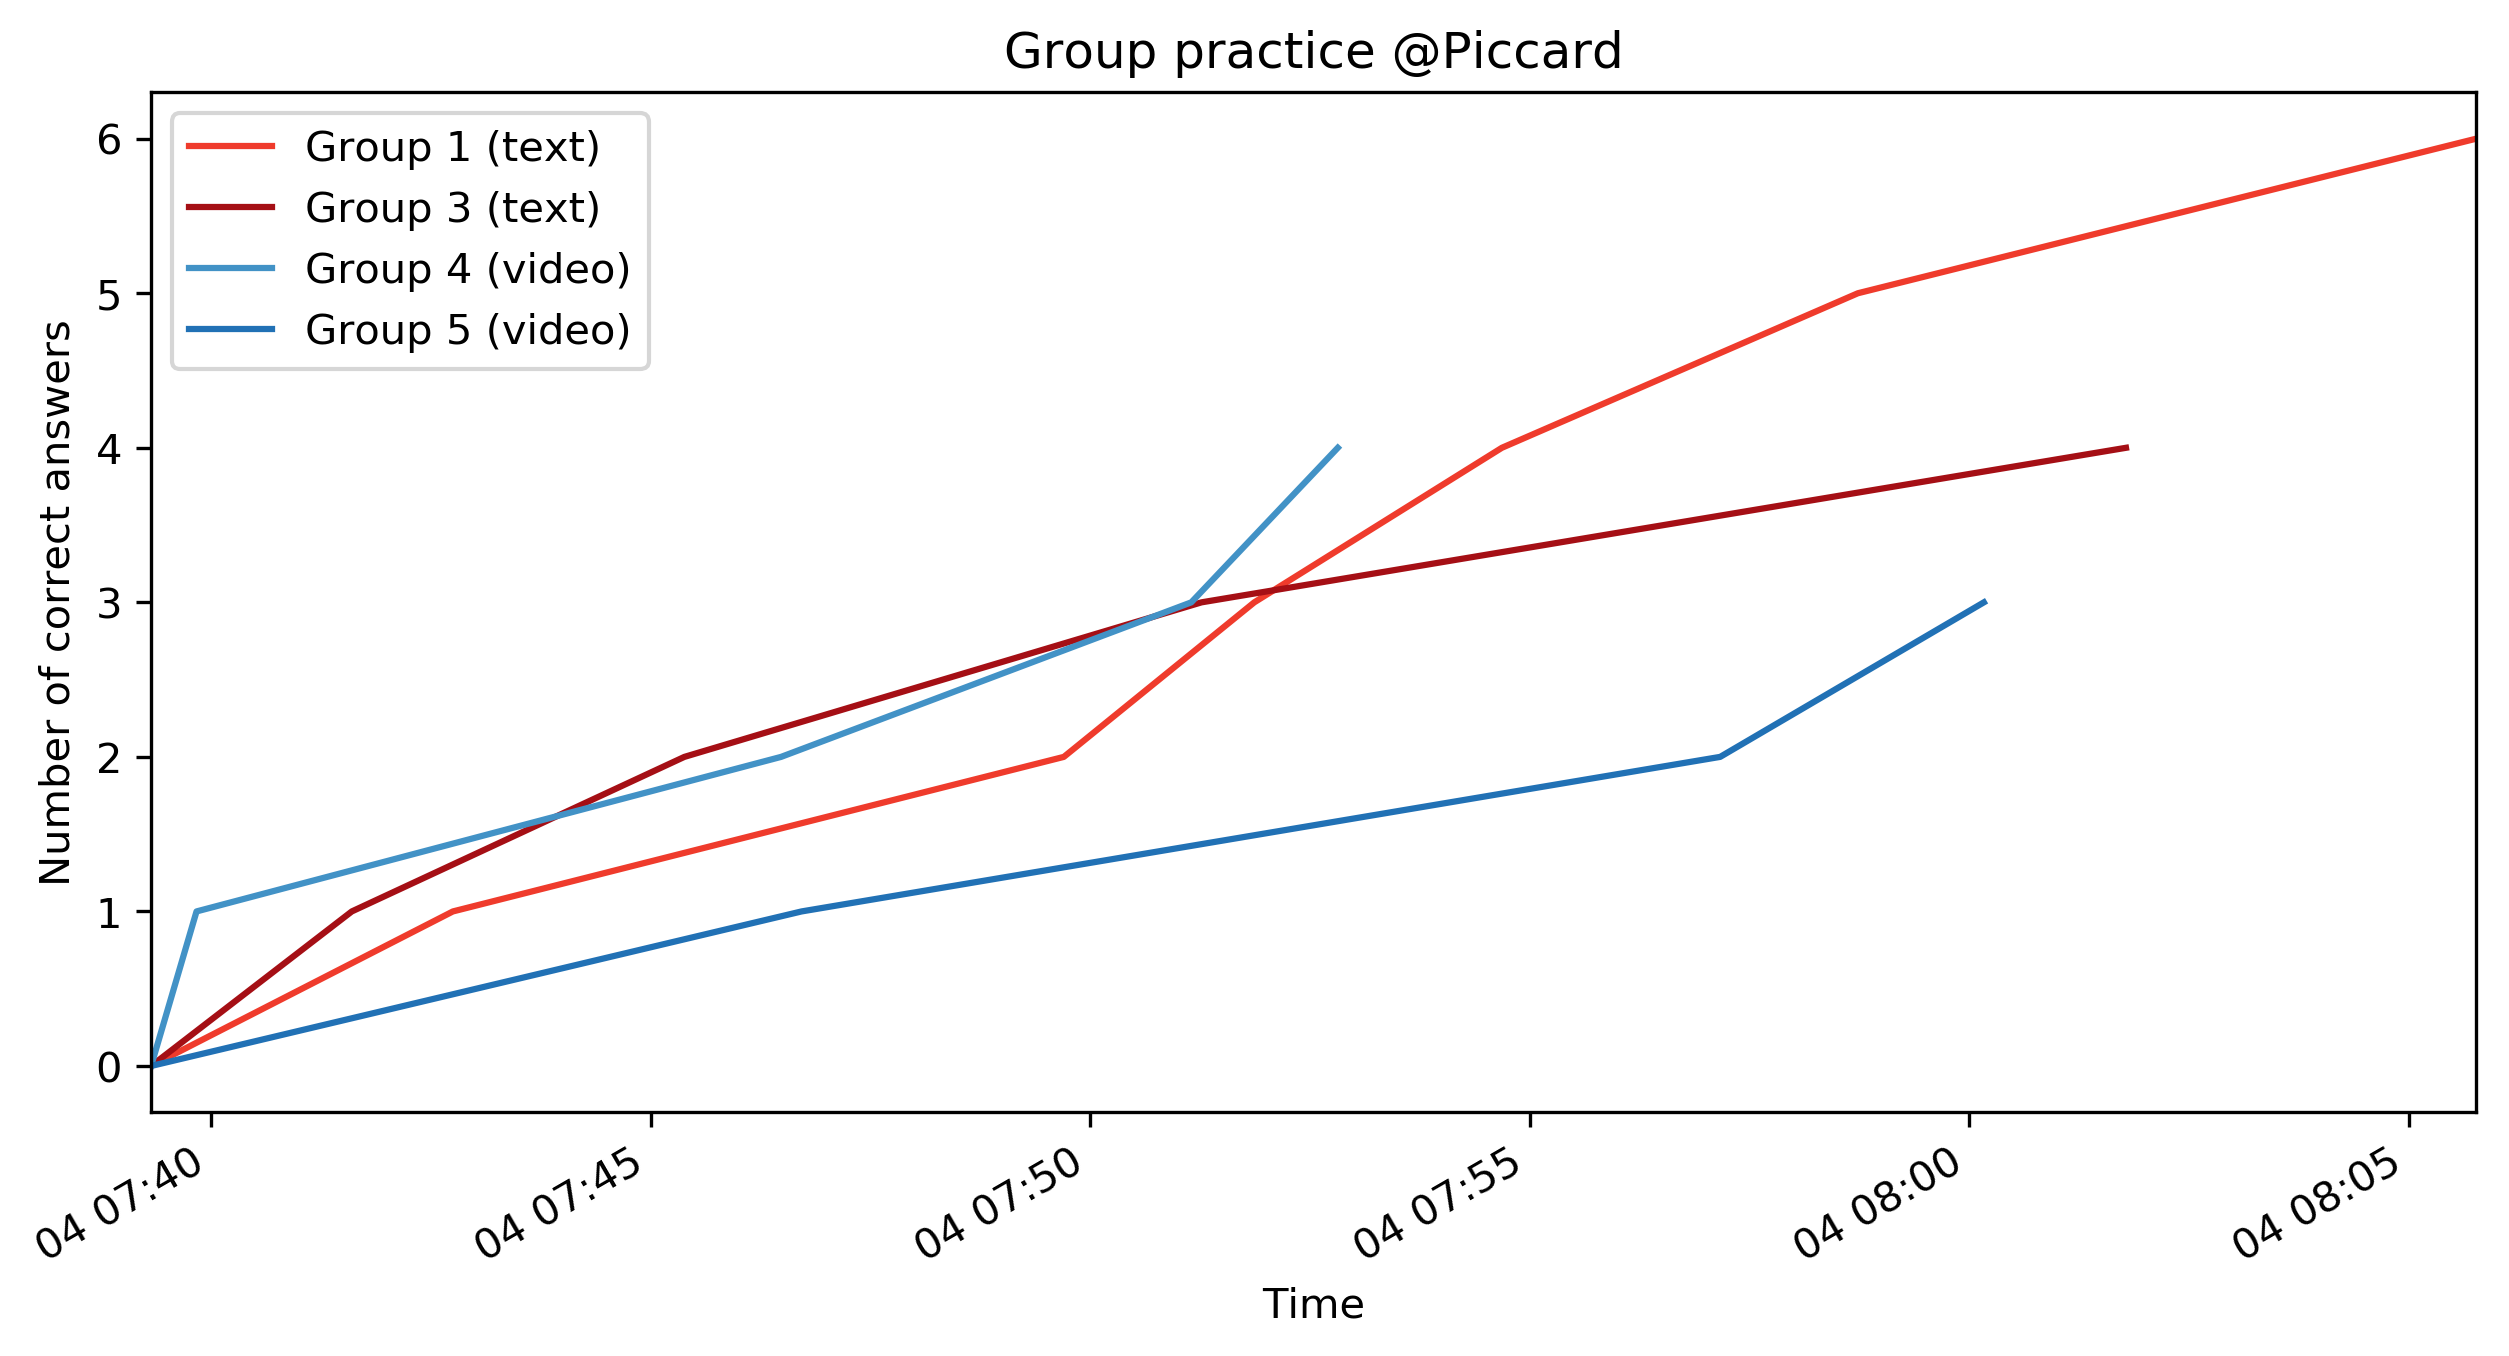

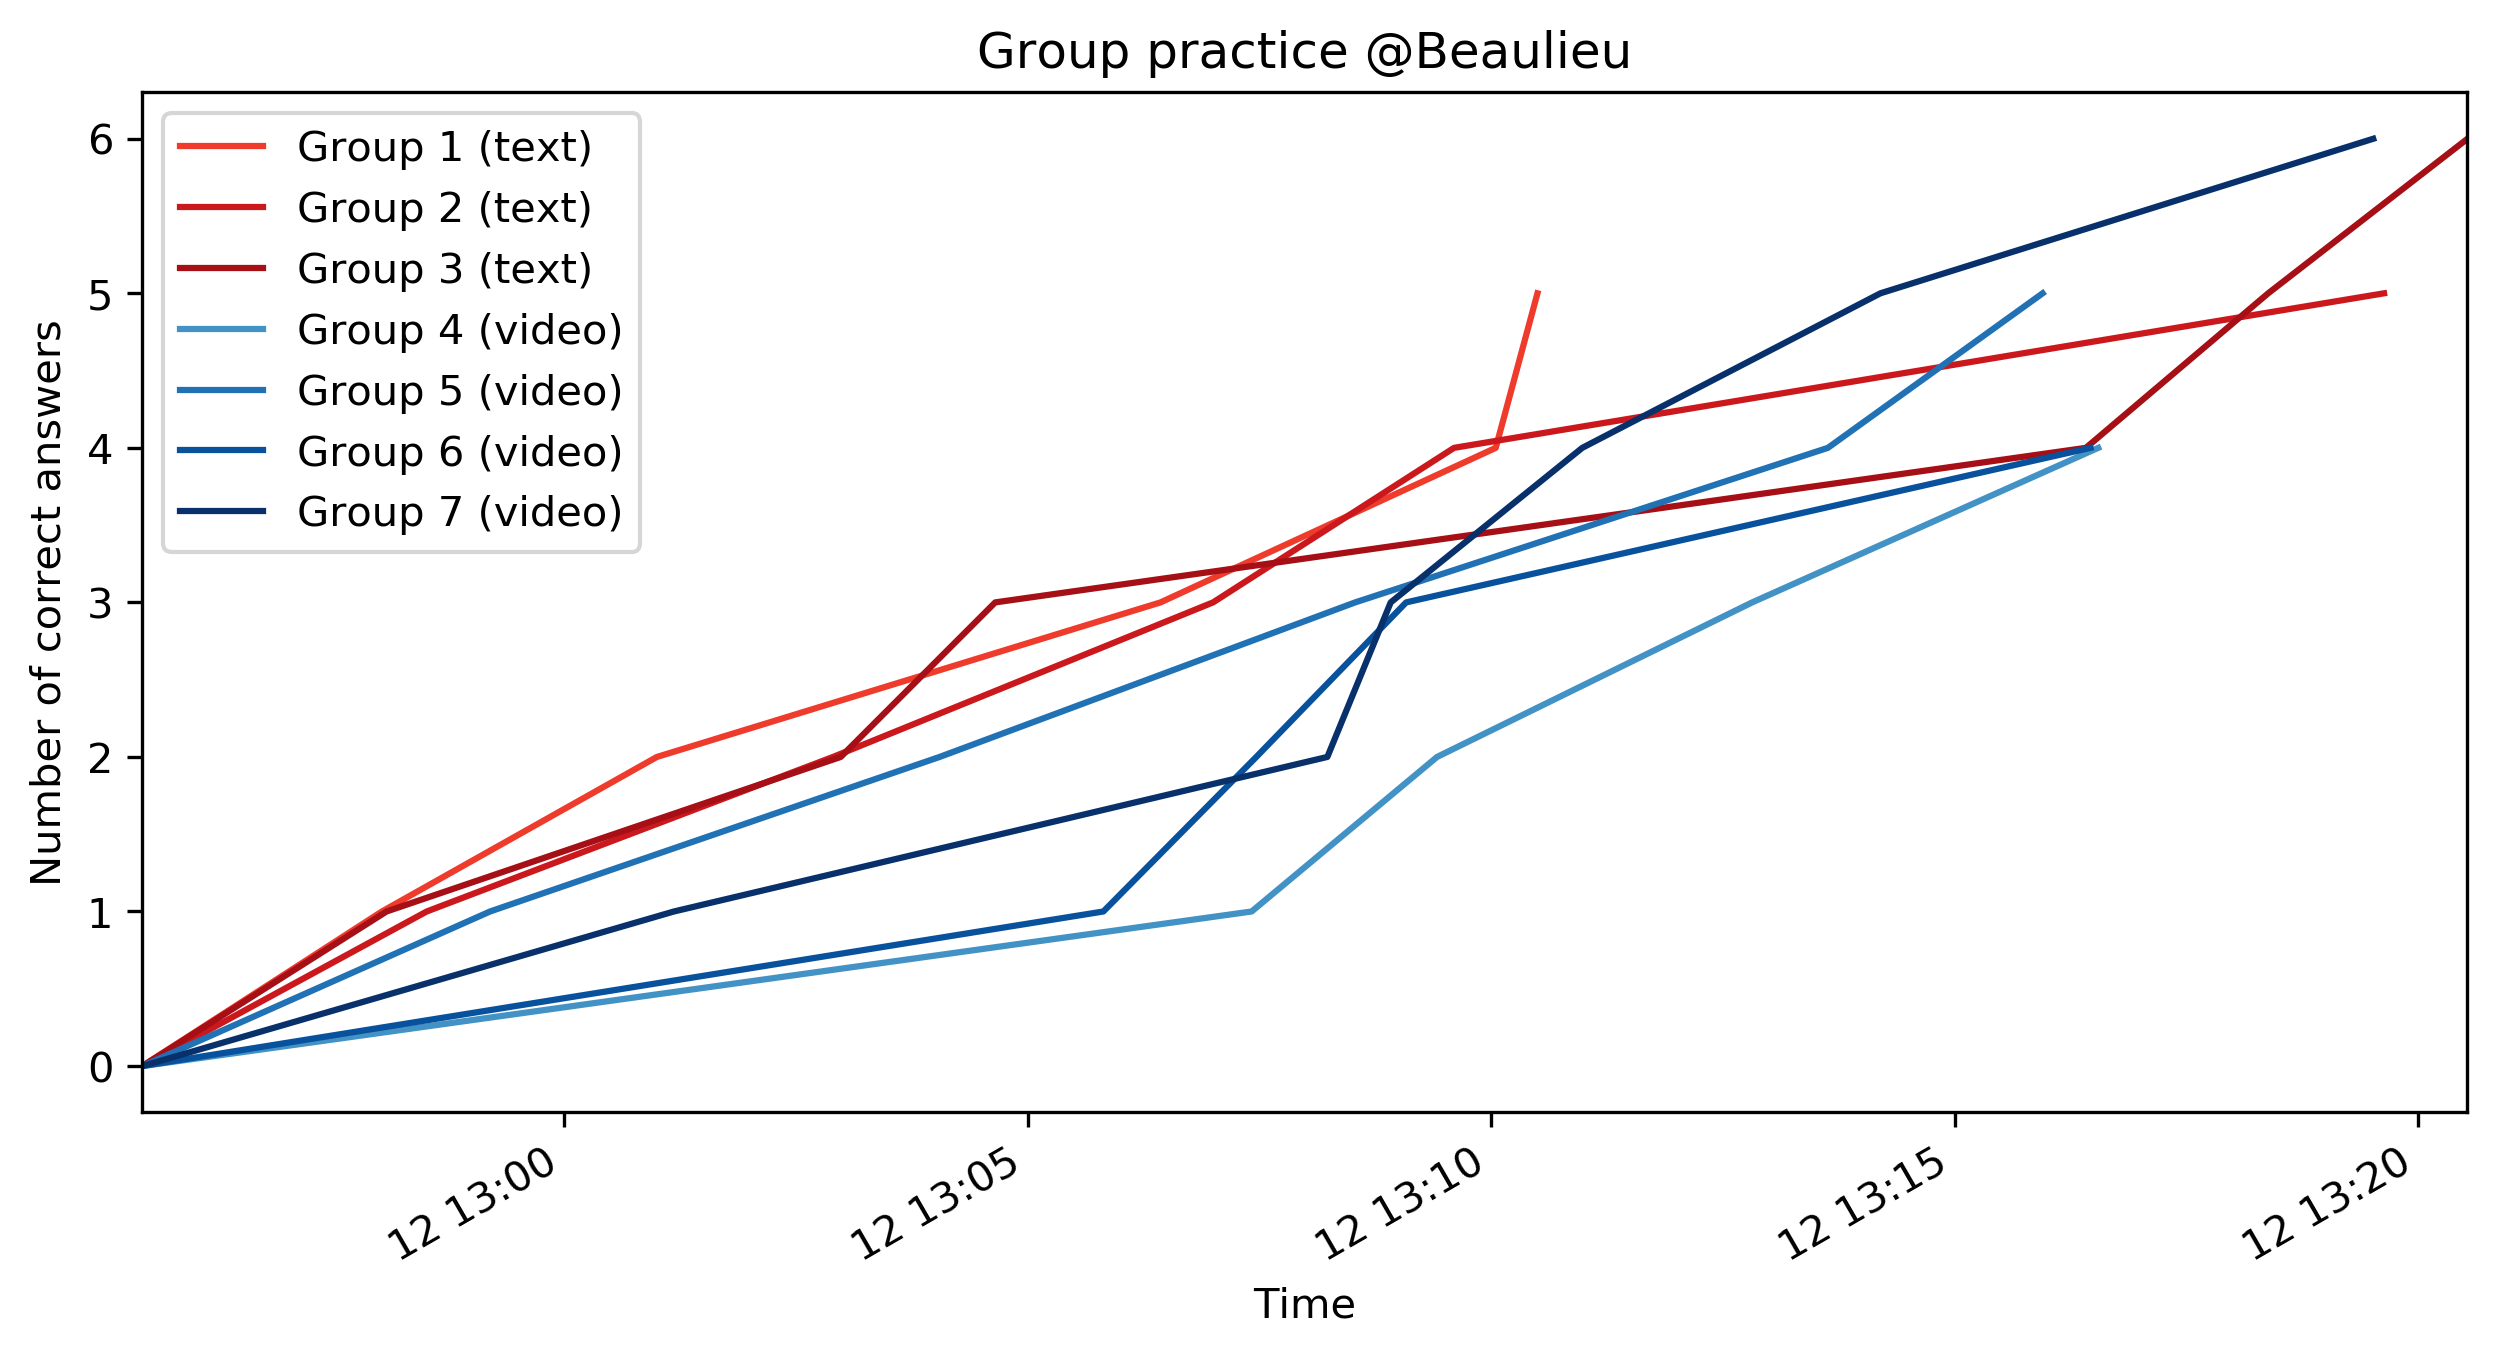

In [103]:
for school in ["piccard", "beaulieu"]:
    logs = read_logs(f"../data/raw/{school}/log.tsv")
    exs_logs = parse_exs_logs(logs)
    score_changes = compute_score_changes(exs_logs)
    plot_score_changes(score_changes, school)

In [97]:
score_changes

,timestamp,groupId,exId,score
0,2019-12-12 12:55:27+00:00,4,-1,0
1,2019-12-12 12:55:27+00:00,6,-1,0
2,2019-12-12 12:55:27+00:00,7,-1,0
3,2019-12-12 12:55:27+00:00,5,-1,0
4,2019-12-12 12:55:27+00:00,2,-1,0
5,2019-12-12 12:55:27+00:00,3,-1,0
6,2019-12-12 12:55:27+00:00,1,-1,0
7,2019-12-12 12:58:02+00:00,1,0,1
8,2019-12-12 12:58:05+00:00,3,0,1
9,2019-12-12 12:58:31+00:00,2,0,1
